In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from sklearn import model_selection, preprocessing, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Download required NLTK datasets
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

Read dataset

In [ ]:
filename = "/kaggle/input/amazon-product-reviews/Reviews.csv"
rev = pd.read_csv(filename)
rev.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
rev.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Visualization

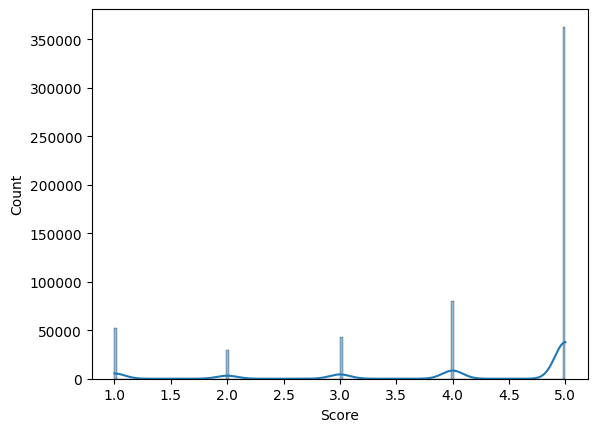

In [ ]:
sns.histplot(rev.Score, kde = True);

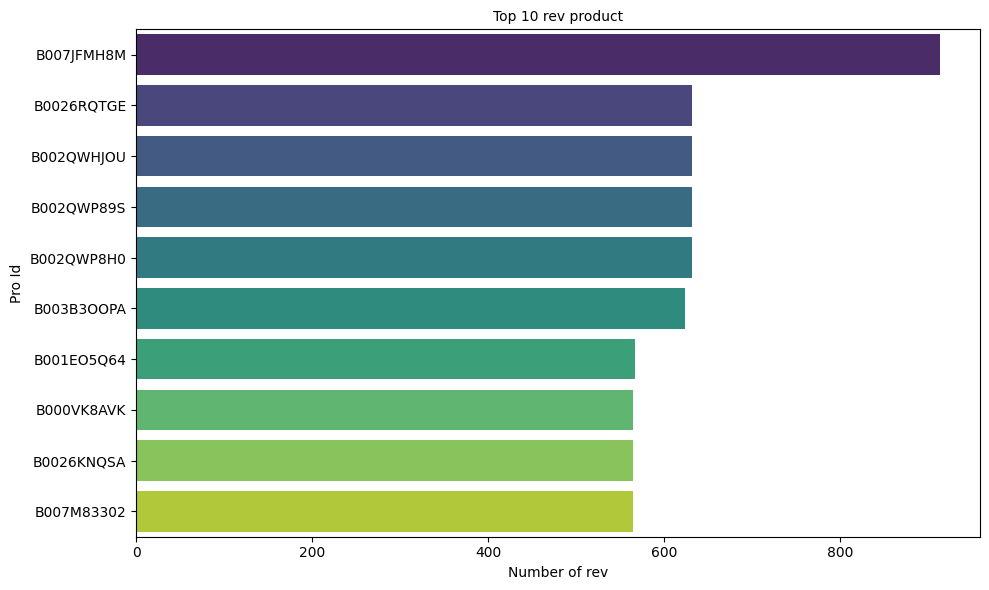

In [ ]:
# Plot top 10 most reviewed products
top_products = rev["ProductId"].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 rev product", fontsize = 10)
plt.xlabel("Number of rev")
plt.ylabel("Pro Id")
plt.tight_layout()
plt.show()

In [ ]:
most_active_users = rev['UserId'].value_counts().head(10)


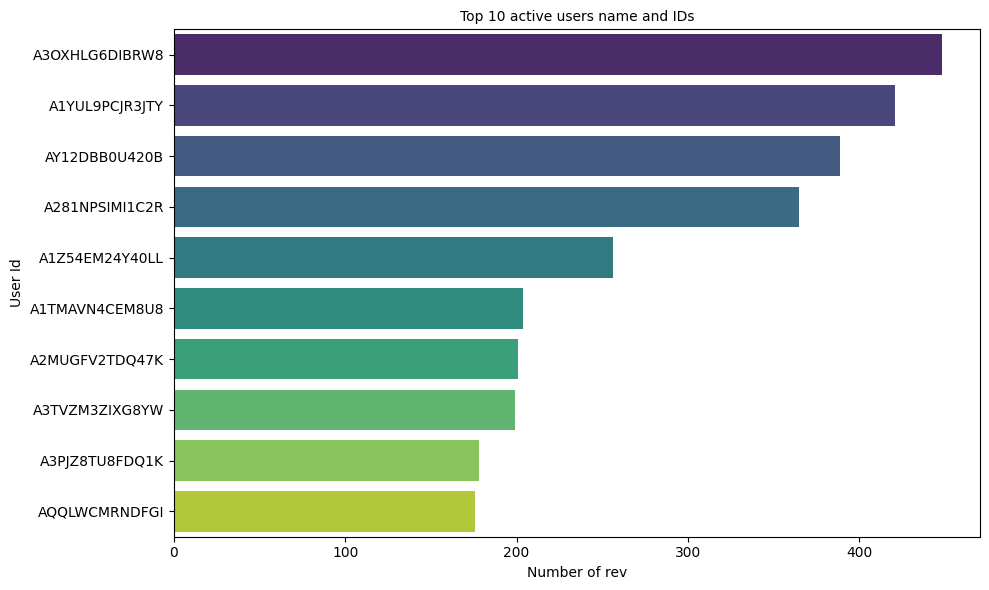

In [ ]:
# Plot top 10 most active users
plt.figure(figsize=(10,6))
sns.barplot(x = most_active_users.values, y = most_active_users.index, palette = "viridis")
plt.title("Top 10 active users name and IDs", fontsize = 10)
plt.xlabel("Number of rev")
plt.ylabel("User Id")
plt.tight_layout()
plt.show()

Data cleaning

In [ ]:
# Data cleaning: drop missing values
df = rev.copy()
df.dropna(inplace = True)
null = df.isnull().sum()
null

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [ ]:
df = df[df["Score"].between(1, 5)]

Preprocessing

In [ ]:
df["combined_text"] = df["Summary"] + " " + df["Text"]

In [ ]:
df_a = df.copy()

In [ ]:
df_a["combined_text"] = df_a["combined_text"].apply(lambda i: " ".join(i.lower() for i in i.split()))

In [ ]:
df_a["combined_text"] = df_a["combined_text"].fillna("").str.replace(r"[^\w\s]", "", regex=True)

In [ ]:
df_a["combined_text"] = df_a["combined_text"].str.replace(r"\d", "", regex=True)

In [ ]:
sw = stopwords.words("english")
df_a["combined_text"] = df_a["combined_text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [ ]:
removed =pd.Series(" ".join(df_a["combined_text"]).split()).value_counts()[-1000:]

In [ ]:
df_a["combined_text"] = df_a["combined_text"].apply(lambda i: " ".join(i for i in i.split() if i not in removed))

In [ ]:
TextBlob(df_a["combined_text"][1]).words
df_a["combined_text"].apply(lambda i:TextBlob(i).words)

0         [good, quality, dog, food, bought, several, vi...
1         [advertised, product, arrived, labeled, jumbo,...
2         [delight, says, confection, around, centuries,...
3         [cough, medicine, looking, secret, ingredient,...
4         [great, taffy, great, taffy, great, price, wid...
                                ...                        
568449    [without, great, sesame, chickenthis, good, be...
568450    [disappointed, im, disappointed, flavor, choco...
568451    [perfect, maltipoo, stars, small, give, one, t...
568452    [favorite, training, reward, treat, best, trea...
568453    [great, honey, satisfied, product, advertised,...
Name: combined_text, Length: 568401, dtype: object

In [ ]:
df_a["combined_text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

0         good quality dog food bought several vitality ...
1         advertised product arrived labeled jumbo salte...
2         delight say confection around century light pi...
3         cough medicine looking secret ingredient robit...
4         great taffy great taffy great price wide assor...
                                ...                        
568449    without great sesame chickenthis good better r...
568450    disappointed im disappointed flavor chocolate ...
568451    perfect maltipoo star small give one training ...
568452    favorite training reward treat best treat trai...
568453    great honey satisfied product advertised use c...
Name: combined_text, Length: 568401, dtype: object

Convert score into sentiment labels

In [ ]:
df_a["Score"].replace(1, value = "negatif", inplace = True)
df_a["Score"].replace(2, value = "negatif", inplace = True)
df_a["Score"].replace(3, value = "middle", inplace = True)
df_a["Score"].replace(4, value = "pozitif", inplace = True)
df_a["Score"].replace(5, value = "pozitif", inplace = True)


In [ ]:
# Train-test split
train_x, test_x, train_y, test_y = model_selection.train_test_split(df["combined_text"], df_a["Score"])

In [ ]:
# Encode labels
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [ ]:
# TF-IDF vectorization (word level)
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

lojistik regresyon / word level

In [ ]:
# Logistic regression with word-level TF-IDF
loj = linear_model.LogisticRegression(max_iter=300)
loj_model = loj.fit(x_train_tf_idf_word, train_y)
# Evaluate model with cross-validation
accuarcy = model_selection.cross_val_score(loj_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           n_jobs= -1,
                                           cv = 10).mean()
print("Accuracy", accuarcy)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy 0.8852365403077801


In [ ]:
# Predict sentiment for a new review
new_review = ["I hate the color of this product"]
new_review_vector = tf_idf_word_vectorizer.transform(new_review)
guest = loj_model.predict(new_review_vector)
print("Prediction" , encoder.inverse_transform(guest))


Prediction ['negatif']
